```{margin} Adaptation!
This lecture was also adapted from lecture notes in John Kitchin's excellent 06-623 course. His lecture notes are included in the helpful resources link if you want to know more details about how numerical methods work. 
```

`````{note}
This lecture is going to:
* introduce the functional form of neural networks
* code a neural network from scratch using numpy/scipy
* show why gradients are so important for fitting models with many parameters
* improve the efficiency of regression using automatic differentiation
* discuss some of the logistical considerations of using and training neural networks
    * mini-batch
    * gradient descent
    * packages, accelerators, etc
`````

## Neural Networks

We've learned how to apply least squares for supervised regression using various types of models
* non-linear models, or linear models with polynomial features: {doc}`notes/nonparametric`
* linear models, polynomial features, regularization (LASSO/ridge):  {doc}`notes/overfitting_regularization`
* non-parametric models: ({doc}`notes/nonparametric`

Today we're going to focus on a specific type of paremetric supervised regression model: **neural networks**! The functional form is quite simple, but using them in practice is going to require some new concepts that we'll cover along the way.

`````{seealso}
* [Neural networks from scratch](https://github.com/karpathy/nn-zero-to-hero)
* [Simpler videos describing neural networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
`````

## Dataset

As a test dataset, let's consider a very simple nonlinear function:
\begin{align*}
y =f(x)= x^\frac{1}{3}+\epsilon
\end{align*}
where $\epsilon$ is a small Gaussian-distributed random error.

Let's generate 50 plots and use a simple 60/20/20 train/val/test split.

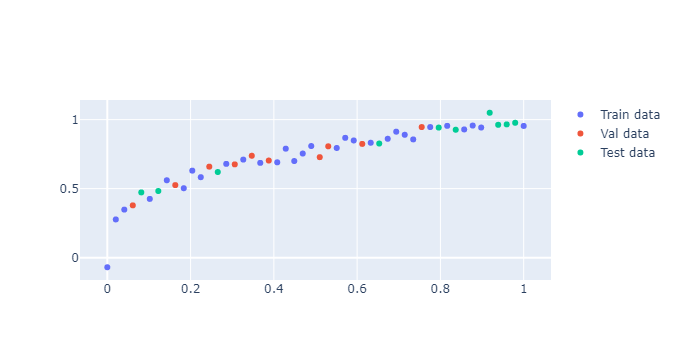

In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

# Generate some data
X = np.linspace(0, 1)
y = X ** (1.0 / 3.0) + np.random.normal(scale=0.03, size=X.shape)

# Train/val/test splits
X_train, X_valtest, y_train, y_valtest = train_test_split(
    X, y, train_size=0.6, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_valtest, y_valtest, train_size=0.5, random_state=42
)

# Plot!
fig = go.Figure()
fig.add_scatter(x=X_train, y=y_train, name="Train data", mode="markers")
fig.add_scatter(x=X_val, y=y_val, name="Val data", mode="markers")
fig.add_scatter(x=X_test, y=y_test, name="Test data", mode="markers")

## Flexible non-linear regression

In polynomial regression (linear regression with polynomial features) we choose a functional form:
\begin{align*}
f(x, \theta) = \theta_0 + \theta_1 x + \theta_2 x^2 + \dots
\end{align*}
where $\theta_i$ were the linear regression parameters that we fitted with least squares minimization.

In this lecture we're going to use a different function
\begin{align*}
y = b_1 + w_{10} \tanh(w_{00} x + b_{00}) + w_{11} \tanh(w_{01} x + b_{01}) + w_{12} \tanh(w_{02} x + b_{02}) + \dots
\end{align*}
where $b_i$ and $w_{ij}$ are fitted parameters. This looks a bit arbitrary, but we'll talk more about why the functional form is helpful and what choices were made here.

First, let's define our model.

In [2]:
def model(x, *pars):

    # Unpack the parameters
    b1, w10, w00, b00, w11, w01, b01, w12, w02, b02 = pars

    # Make the prediction
    pred = (
        b1
        + w10 * np.tanh(w00 * x + b00)
        + w11 * np.tanh(w01 * x + b01)
        + w12 * np.tanh(w02 * x + b02)
    )
    return pred

Now, let's fit it with simple least squares minimization.

In [3]:
from scipy.optimize import minimize


# Sum squared error loss function! No regularization yet.
def loss(parameters, X, y):
    y_pred = model(X, *parameters)
    loss = sum((y - y_pred) ** 2)
    return loss


# Least squares regression fit using scipy.optimize.minimize
sol = minimize(
    loss,
    np.random.normal(size=(10,)),
    args=(X_train, y_train),
)
print(sol.x)

[-31.85638774 -30.74510759 -87.42384808  -2.66086243  -0.57382642
  -6.77888324  -0.83038082   1.66128603   0.89083244   0.65010117]


Let's see how this worked!

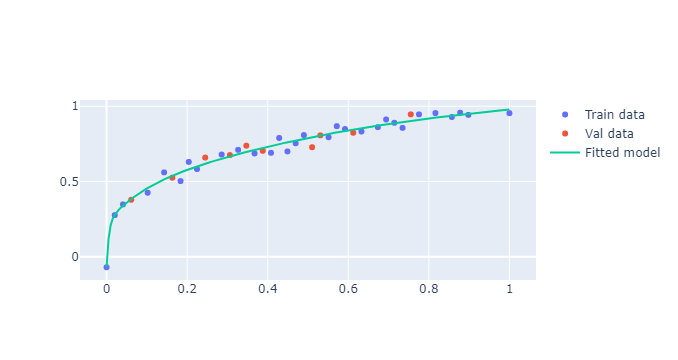

In [4]:
fig = go.Figure()
fig.add_scatter(x=X_train, y=y_train, name="Train data", mode="markers")
fig.add_scatter(x=X_val, y=y_val, name="Val data", mode="markers")
fig.add_scatter(
    x=np.linspace(0, 1, 200),
    y=model(np.linspace(0, 1, 200), *sol.x),
    name="Fitted model",
)

Let's inspect the parameter values. They sometimes vary by some orders of magnitude. This should make you think about using some regularization.

In [5]:
print(sol.x)

[-31.85638774 -30.74510759 -87.42384808  -2.66086243  -0.57382642
  -6.77888324  -0.83038082   1.66128603   0.89083244   0.65010117]


## Neural network extrapolation 

Let's also check how this model extrapolates. We have fitted a nonlinear model to the data, and so we should not expect it to extrapolate reliably. We can show this is the case explicitly:

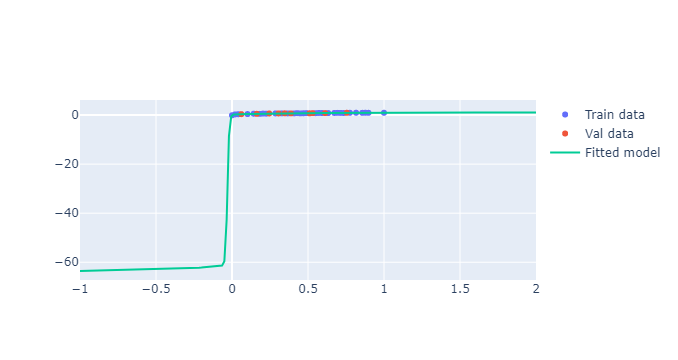

In [6]:
fig = go.Figure()
fig.add_scatter(x=X_train, y=y_train, name="Train data", mode="markers")
fig.add_scatter(x=X_val, y=y_val, name="Val data", mode="markers")
fig.add_scatter(
    x=np.linspace(-1, 2, 200),  # Plot x from -1 to 2
    y=model(np.linspace(-1, 2, 200), *sol.x),
    name="Fitted model",
)

You can see that this model starts failing at $x>1$. At very large $x$ it will start to level out. What defines large $x$ is unclear though, in this specific example, it is around 400. That might be anticipated from knowledge of the `np.tanh` function, it also saturates at large values of $x$.

Try negative numbers too. The real function becomes imaginary, but not our fitted one.


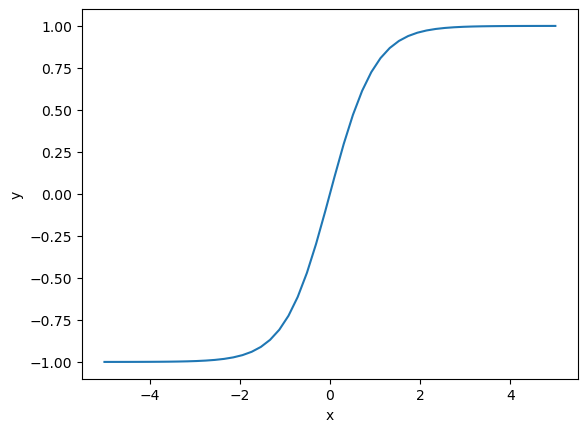

In [7]:
import matplotlib.pyplot as plt

tx = np.linspace(-5, 5)
plt.plot(tx, np.tanh(tx))
plt.xlabel("x")
plt.ylabel("y");

### Practice

Run the above sequence several times with new initializations. You should get equally good fits, but different parameters. These models are not unique. That is one thing many people do not like about machine learning. 

How do the different extrapolations look?

### Reproducibility of neural networks

If you run the above code, you will get difference answers and model fits each time. This is mainly due to the random weight and bias initializations. If we add a random number seed, then the results become reproducible but highly variable. This stochastic nature is a downside to neural network training

In [32]:
from scipy.optimize import minimize


# Sum squared error loss function! No regularization yet.
def loss(parameters, X, y):
    y_pred = model(X, *parameters)
    loss = sum((y - y_pred) ** 2)
    return loss

np.random.seed(42)

# Least squares regression fit using scipy.optimize.minimize
sol = minimize(
    loss,
    np.random.normal(size=(10,)),
    args=(X_train, y_train),
)
print(sol.x)

[-32.46154965  20.63327671   0.98442518   1.99438721 -12.48788683
  38.07530142  25.83436393  25.39308246  37.39380834   2.42401464]


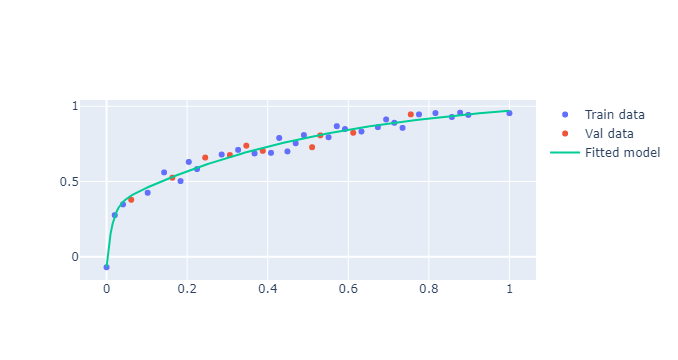

In [33]:
fig = go.Figure()
fig.add_scatter(x=X_train, y=y_train, name="Train data", mode="markers")
fig.add_scatter(x=X_val, y=y_val, name="Val data", mode="markers")
fig.add_scatter(
    x=np.linspace(0, 1, 200),  # Plot x from -1 to 2
    y=model(np.linspace(0, 1, 200), *sol.x),
    name="Fitted model",
)

## Neural Network Structure

Up to here, this is mostly review for us. It is just a nonlinear regression (admittedly to a strange looking function), and analysis of the resulting model. Note that the model is very flexible, and it can be used to fit a variety of other functions.

I did not pull that model out of nowhere. Let's rewrite it in a few steps. If we think of `tanh` as a function that operates element-wise on a vector, we could write that equation more compactly at:

                                  [w00 * x + b01]
    y = [w10, w11, w12] @ np.tanh([w01 * x + b01]) + b1
                                  [w02 * x + b02]

We can rewrite this one more time in matrix notation:

    y = w1 @ np.tanh(w0 @ x + b0) + b1

Another way to read these equations is that we have an input of $x$. We multiply the input by a vector weights ($\mathbf{w0}$), add a vector of offsets (biases), $\mathbf{b0}$, *activate* that by the nonlinear `tanh` function, then multiply that by a new set of weights, and add a final bias. We typically call this kind of model a *neural network*. There is an input layer, one hidden layer with 3 neurons that are activated by `tanh`, and one output layer with linear activation.

A conventional graphical representation of this function as a neural network is shown here:

![neural network](resources/nn.png)


These models are called neural networks because they were originally modeled after neurons. Neurons take input, and if the input is large enough the neuron is activated and has an output. The `tanh` function approximates this behavior in a smooth, differentiable way. Remarkably, neural networks have been shown to be universal function approximators and hence they are extremely useful.

When you use a neural network, you have several choices to make:

1.  How many layers? Here we used one layer, but it is possible to have many layers where the output of the first layer goes to the second layer, etc.  This increases the flexibility of the network.
2.  How many neurons should be in each layer? The more neurons you use, the more parameters there will be. This increases the flexibility of the network.
3.  What activation function to use. The classics are tanh and sigmoid functions, but almost any nonlinear function can be used.

In machine learning lingo, these choices are called **hyperparameters**. These are parameters that determine the size of the model, but they are fixed, and not fitted as part of the model. It is mostly **art and experience** that is how these choices are made. There are many advanced methods for doing this more systematically, but they are computationally expensive and beyond the scope of this class.



### Another interpretation of neural networks



In this section we consider another interpretation of what a neural network is. We start with a partial Fourier series expansion of a periodic function ([http://mathworld.wolfram.com/FourierSeries.html](http://mathworld.wolfram.com/FourierSeries.html)). This expansion can fit any even periodic function in the infinite limit, and can approximate that function otherwise.

$f(x) = \frac{1}{2} a_0 + \sum_{n=1}^{\infty} a_n \cos(n x)$

We use a partial series (leaving out the sin terms) just for simplicity of notation here. Next, we write this in a vector form. In the Fourier series, the $a_n$ have formal definitions: $a_n = \int_{-\pi}^{\pi} f(x) cos(n x) dx$.  Let $\mathbf{a} = [a_0, a_1, a_2, ..., a_n]$, and $\mathbf{n} = [1, 2, .., n]$ Then, we can replace the sum as $\mathbf{a} \cdot \cos(\mathbf{n} x)$. We can for now imagine that $n$ could go to $\infty$, but it is not critical; if we truncate the expansion, then we just have an approximate expansion.


We can represent this in a graph form like a neural network:


![img](resources/cos-network.png)

To get to a neural network, we relax a few things. First, we let $n$ take on continuous values that are determined by fitting, not just integer values. Second, we let $a_n$ become a fitting parameter, rather than computing it from the definition. Third, we allow other functions than $\cos$ to "activate" the layers. In this sense, we can see that a single layer neural network is like an expansion in a basis set of the activation functions, with a more flexible definition of their form.

A network can have multiple layers, and we interpret these as a composition of functions, e.g. f(g(x)), where the second layer serves to nonlinearly transform the output of the first layer.  Thus, "deep learning" provides a nonlinear transform of your input space to a new space with different dimensionality where the output is linear in this new space.



## Faster optimization using automatic differentiation

We now have some understanding of what a neural network is, and we've coded one from scratch and optimized it with `minimize`. 

In practice, we might use very large neural networks or fit them to a very large amount of data. This might make the loss function very slow, or take many optimizer steps in order to converge. We can make this process much more efficient by also using the gradients of the loss function in the optimization!

### Base case (local optimization of parameters without gradients)

First, let's repeat the optimization we did above and see how many calls to the loss function were needed to fit the parameters. 

In [8]:
def model(x, *pars):
    # Unpack the parameters
    b1, w10, w00, b00, w11, w01, b01, w12, w02, b02 = pars

    # Make the prediction
    pred = (
        b1
        + w10 * np.tanh(w00 * x + b00)
        + w11 * np.tanh(w01 * x + b01)
        + w12 * np.tanh(w02 * x + b02)
    )
    return pred


# Sum squared error loss function! No regularization yet.
def loss(parameters, X, y):
    y_pred = model(X, *parameters)
    loss = sum((y - y_pred) ** 2)
    return loss


# Least squares regression fit using scipy.optimize.minimize
sol = minimize(
    loss,
    np.random.normal(size=(10,)),
    args=(X_train, y_train),
)

print(f"It took {sol.nfev} function evaluations to fit our simple neural network!")

It took 10330 function evaluations to fit our simple neural network!


Try repeating this code a few times. We need many function evaluations since we're optimizing 10 parameters simultaneously. Some of the largest neural networks have >100 billion parameters, so imagine how expensive this might be!

### Local optimization of parameters with analytical Jacobian

Our optimization involves adjusting each of the parameters one by one, so the derivative of the output with respect to each of the parameters is helpful.

In [9]:
def model(x, *pars):
    # Unpack the parameters
    b1, w10, w00, b00, w11, w01, b01, w12, w02, b02 = pars

    # Make the prediction
    pred = (
        b1
        + w10 * np.tanh(w00 * x + b00)
        + w11 * np.tanh(w01 * x + b01)
        + w12 * np.tanh(w02 * x + b02)
    )
    return pred


# I did this by hand, going through and calculating the derivative of y
# with respect to each of the parameters
def dmodeldparams(x, *pars):
    b1, w10, w00, b00, w11, w01, b01, w12, w02, b02 = pars

    dydparams = [
        [1] * len(x),  # dy/db1
        np.tanh(w00 * x + b00),  # dy/dw10
        w10 * x * (1 - np.tanh(w00 * x + b00) ** 2),  # dy/dw00
        w10 * (1 - np.tanh(w00 * x + b00) ** 2),  # dy/db00
        np.tanh(w01 * x + b01),  # dy/dw11
        w11 * x * (1 - np.tanh(w01 * x + b01) ** 2),  # dy/dw01
        w11 * (1 - np.tanh(w01 * x + b01) ** 2),  # dy/db01
        np.tanh(w02 * x + b02),  # dy/dw12
        w12 * x * (1 - np.tanh(w02 * x + b02) ** 2),  # dy/dw02
        w12 * (1 - np.tanh(w02 * x + b02) ** 2),  # dy/db02
    ]
    return np.array(dydparams)


def jacobian(parameters, X, y):
    # Unpack the parameters
    b1, w10, w00, b00, w11, w01, b01, w12, w02, b02 = parameters

    # analytical jacobian!
    jac = -2 * (y - model(X, *parameters)) @ dmodeldparams(X, *parameters).T
    return jac


# Sum squared error loss function! No regularization yet.
def loss(parameters, X, y):
    y_pred = model(X, *parameters)
    loss = sum((y - y_pred) ** 2)
    return loss


# Least squares regression fit using scipy.optimize.minimize
sol = minimize(
    loss,
    np.random.normal(size=(10,)),
    jac=jacobian,
    args=(X_train, y_train),
)

print(f"It took {sol.nfev} function evaluations to fit our simple neural network!")

It took 2425 function evaluations to fit our simple neural network!


In [10]:
print(sol.fun)

0.05397504210993263


This is ~10X fewer function evaluations than our original model, although we did have to do some extra calculations for the jacobian. 

The downside is that I had to spend a lot of time calculating the Jacobian very carefully. I could do it since this model was very simple, but anything more complicated would basically be impossible to implement!

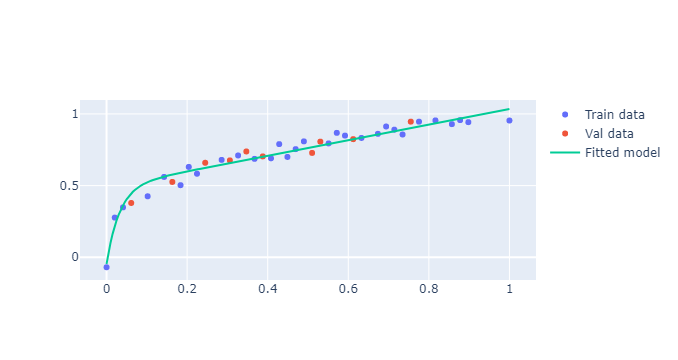

In [11]:
fig = go.Figure()
fig.add_scatter(x=X_train, y=y_train, name="Train data", mode="markers")
fig.add_scatter(x=X_val, y=y_val, name="Val data", mode="markers")
fig.add_scatter(
    x=np.linspace(0, 1, 200),  # Plot x from -1 to 2
    y=model(np.linspace(0, 1, 200), *sol.x),
    name="Fitted model",
)

### Local optimization of parameters with Jacobian from automatic differentiation (jax)

Fitting neural networks is basically impossible if you don't have a way of calculating the gradients of the loss function. The computer science and ML communities have come up with a number of clever approaches to calculate the gradients of a computer function analytically. A couple of the most common languages right now (among many many options!) are
* [pytorch](https://pytorch.org/)
* [tensorflow](https://www.tensorflow.org/)
* [jax](https://jax.readthedocs.io/en/latest/)

Most research machine learning codes are written in pytorch right now, but it's a little complicated to demonstrate. We're going to use jax just to show that it's possible to get the gradients very quickly using automatic differentiation!

`````{seealso}
https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html
`````

In [12]:
import jax.numpy as jnp
import jax.scipy.optimize
from jax.config import config

config.update("jax_enable_x64", True)


def model(x, *pars):
    # Unpack the parameters
    b1, w10, w00, b00, w11, w01, b01, w12, w02, b02 = pars

    # Make the prediction
    pred = (
        b1
        + w10 * jnp.tanh(w00 * x + b00)
        + w11 * jnp.tanh(w01 * x + b01)
        + w12 * jnp.tanh(w02 * x + b02)
    )
    return pred


# Sum squared error loss function! No regularization yet.
def loss(parameters, X, y):
    y_pred = model(X, *parameters)
    loss = jnp.sum((y - y_pred) ** 2)
    print(loss)
    return loss


key = jax.random.PRNGKey(19)  # for reproducibility
initial_parameters = jax.random.normal(key, shape=(10,))

# jax.scipy.optimize will automatically calculate the gradients using backpropagation!
sol = jax.scipy.optimize.minimize(
    loss,
    initial_parameters,
    method="BFGS",
    args=(jnp.asarray(X_train), jnp.asarray(y_train)),
)

print(f"It took {sol.nfev} function evaluations to fit our simple neural network!")

Traced<ConcreteArray(100.33631207066287, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(100.33631207, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe5ca0b9960>, in_tracers=(Traced<ShapedArray(float64[30]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x7fe5c85cd6d0; to 'JaxprTracer' at 0x7fe5c85cd630>], out_avals=[ShapedArray(float64[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': '_reduce_sum', 'donated_invars': (False,), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f64[30]. let b:f64[] = reduce_sum[axes=(0,)] a in (b,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fe5c85d28b0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
Traced<ShapedArray(float64[])>with<JVPTrace(level=4/0)> with
  primal = Traced<ShapedAr

The number of model calls is a little suspicious here - there is probably a small difference either in the optimizer or convergence settings.

The key to the magic is that jax can automatically calculate the gradient (Jacobian) of the loss function with respect to parameters in the model.  This is way easier than the math that I had to do above! We can see this with a simple example.

In [13]:
jax.grad(loss)(sol.x, X_train, y_train)

Traced<ConcreteArray(0.30863663143564135, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.30863663, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe5c83f63d0>, in_tracers=(Traced<ShapedArray(float64[30]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x7fe5d32ed4a0; to 'JaxprTracer' at 0x7fe5d32ed7c0>], out_avals=[ShapedArray(float64[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': '_reduce_sum', 'donated_invars': (False,), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f64[30]. let b:f64[] = reduce_sum[axes=(0,)] a in (b,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fe5c8630330>, name_stack=NameStack(stack=(Transform(name='jvp'),))))


DeviceArray([ 0.99475946, -0.8894434 ,  0.0933488 ,  0.13650701,
             -0.9346242 ,  0.00299168, -0.1320536 , -0.00190996,
              0.05494958,  0.1441574 ], dtype=float64)

Finally, let's double check out model is actually fitting correctly.

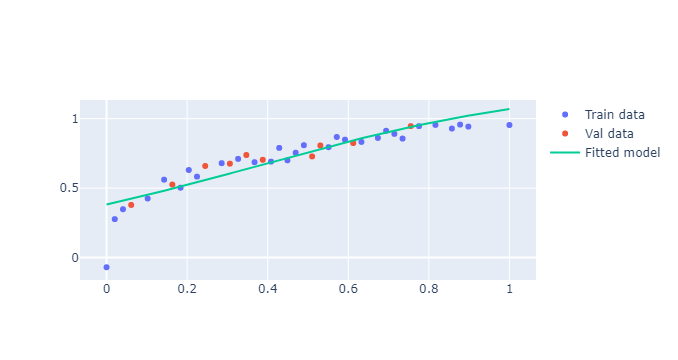

In [14]:
fig = go.Figure()
fig.add_scatter(x=X_train, y=y_train, name="Train data", mode="markers")
fig.add_scatter(x=X_val, y=y_val, name="Val data", mode="markers")
fig.add_scatter(
    x=np.linspace(0, 1, 200),  # Plot x from -1 to 2
    y=model(np.linspace(0, 1, 200), *sol.x),
    name="Fitted model",
)

## Neural networks in scikit-learn

Not surprisingly, scikit-learn also has an implementation for these neural networks. It's convenient in that it has the same interface as other scikit-learn models, but it's not very flexible or particularly fast. 

`````{seealso}
https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised
`````


In [15]:
from sklearn.neural_network import MLPRegressor

# Very simple! Notice that the model we used above corresponds to one very specific set of choices for this MLP
MLPR = MLPRegressor(
    hidden_layer_sizes=(3,), activation="tanh", solver="lbfgs", alpha=0, tol=1e-6
)

# Fit!
MLPR.fit(X_train.reshape((-1, 1)), y_train)

MLPRegressor(activation='tanh', alpha=0, hidden_layer_sizes=(3,),
             solver='lbfgs', tol=1e-06)

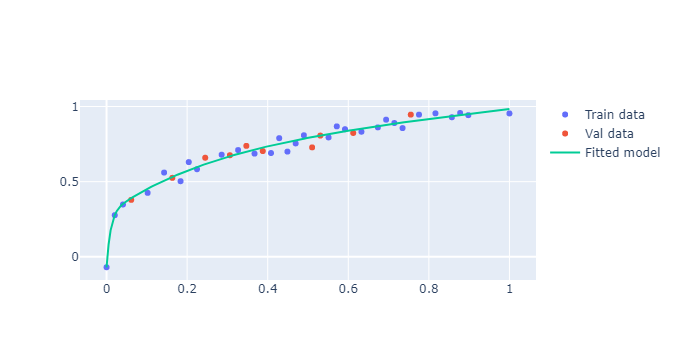

In [16]:
fig = go.Figure()
fig.add_scatter(x=X_train, y=y_train, name="Train data", mode="markers")
fig.add_scatter(x=X_val, y=y_val, name="Val data", mode="markers")
fig.add_scatter(
    x=np.linspace(0, 1, 200),  # Plot x from -1 to 2
    y=MLPR.predict(np.linspace(0, 1, 200).reshape((-1, 1))),
    name="Fitted model",
)

## Practical considerations for training neural networks

Much of the progress and recent excitement for neural networks and deep learning comes from improvements in the practical implementation and training of these networks. A few of the things you will probably see if you dig into this in more detail:
* The size and structure of the neural network can be varied
* There are many possible activation functions
* Neural networks be quite slow to train, but it is much faster if you use a GPU (graphic processing unit) like you would see in a gaming computer. Very big networks might use hundreds of GPUs for training!
* If the neural network or dataset is very large, you probably can't calculate the full loss function for all the data, so instead you only show the model a little bit of data in each iteration (called mini-batching)
* There are many possible sets of parameters that can fit the data, and it's easy to get trapped in a local minimum. There are special optimizers that are more likely to find more global optima, especially when combined with mini-batching from above. 
* There is quite a bit of software engineering to implement state-of-the-art neural networks, but there are increasingly many packages to make this easy and take care of the details (jax, pytorch, pytorch lightning, keras, etc etc)